In [1]:
# Import datasets

from datasets import load_dataset
import pandas as pd

ds = load_dataset("GalaktischeGurke/emails_5500_to_7500")
df = ds["train"].to_pandas()

In [2]:
# Preprocessing the data

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_text(text):
    
    # Remove From:, Sent:, To:, Cc:, Subject: lines
    text = re.sub(r'(?i)^from:.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'(?i)^sent:.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'(?i)^to:.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'(?i)^cc:.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'(?i)^subject:.*$', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', text)
    
    #Erase words except English and numbers
    text = re.sub(r'[^\w\s.,!?]', '', text)

    return text

for i in range(df.shape[1]):
    df.iloc[:, i] = df.iloc[:, i].apply(preprocess_text)

In [3]:
# Feature extraction. Vectorize the email by sentence transformers. 

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Small and fast
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/613 [00:00<?, ?it/s]

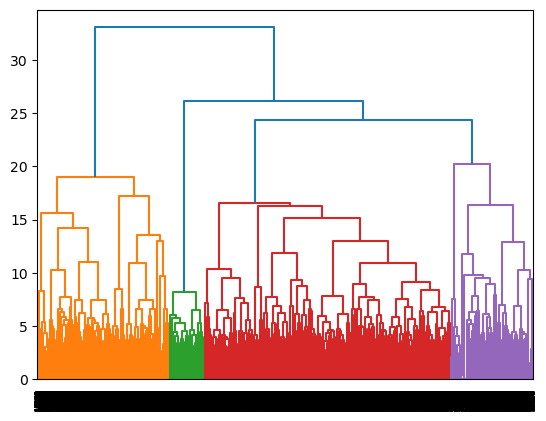

In [4]:
# Plot the dendrogram

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linked = linkage(embeddings, method='ward', metric='euclidean')
dendrogram(linked)
plt.show()

In [5]:
# Apply Hierarchy clustering

labels = fcluster(linked, t=4, criterion='maxclust')-1

In [6]:
# Transform the data into PyTorch
# Split the data into the training set(80%) and the test set(20%)

import torch
from sklearn.model_selection import train_test_split

x = torch.tensor(embeddings, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Define the Deep Neural Network

import torch.nn as nn

class MultilayerPerceptron(nn.Module):
    
    def __init__(self, num_features, hidden_size1, hidden_size2, num_classes):
        super(MultilayerPerceptron, self).__init__()
        # 1st hidden layer
        self.linear_1 = nn.Linear(num_features, hidden_size1)
        # 2nd linear layer
        self.linear_2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear_out = nn.Linear(hidden_size2, num_classes)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        logits = self.linear_out(x)
        
        return logits

In [8]:
# Train the model

import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

learning_rate = 0.01
epochs = 100
dataset = TensorDataset(x_train, y_train)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_features = 384

# Create the neural network model
model = MultilayerPerceptron(num_features, 64, 32, 4)

# Nuber of data for each group is unbalanced → Use class weight for loss function
y_train_np = y_train.numpy().ravel()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define a loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define an optimizer (SGD)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        batch_y = batch_y.squeeze().long()
        loss = loss_fn(outputs, batch_y)
        total_loss += loss.item()
        num_batches += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    avg_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/100], Average Loss: 1.3830
Epoch [2/100], Average Loss: 1.3703
Epoch [3/100], Average Loss: 1.3086
Epoch [4/100], Average Loss: 0.9879
Epoch [5/100], Average Loss: 0.6034
Epoch [6/100], Average Loss: 0.3899
Epoch [7/100], Average Loss: 0.3125
Epoch [8/100], Average Loss: 0.2702
Epoch [9/100], Average Loss: 0.2417
Epoch [10/100], Average Loss: 0.2209
Epoch [11/100], Average Loss: 0.2051
Epoch [12/100], Average Loss: 0.1933
Epoch [13/100], Average Loss: 0.1839
Epoch [14/100], Average Loss: 0.1760
Epoch [15/100], Average Loss: 0.1669
Epoch [16/100], Average Loss: 0.1615
Epoch [17/100], Average Loss: 0.1552
Epoch [18/100], Average Loss: 0.1499
Epoch [19/100], Average Loss: 0.1439
Epoch [20/100], Average Loss: 0.1412
Epoch [21/100], Average Loss: 0.1369
Epoch [22/100], Average Loss: 0.1345
Epoch [23/100], Average Loss: 0.1289
Epoch [24/100], Average Loss: 0.1258
Epoch [25/100], Average Loss: 0.1234
Epoch [26/100], Average Loss: 0.1185
Epoch [27/100], Average Loss: 0.1160
Epoch [28/

In [9]:
# Testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
total_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    outputs = model(x_test)
    preds = torch.argmax(outputs, dim=1)
all_preds.extend(preds.numpy().flatten())
all_labels.extend(y_test.numpy().flatten())

# Calculate accuracy, precision, recall, and f1score
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)

# Print results
print(f"  Accuracy: {acc:.4f}")
for i in range(len(precision)):
    print(f"\nCluster {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")

  Accuracy: 0.9862

Cluster 0:
  Precision: 0.9749
  Recall:    0.9931
  F1 Score:  0.9839

Cluster 1:
  Precision: 0.9961
  Recall:    1.0000
  F1 Score:  0.9980

Cluster 2:
  Precision: 0.9944
  Recall:    0.9800
  F1 Score:  0.9871

Cluster 3:
  Precision: 0.9759
  Recall:    0.9893
  F1 Score:  0.9826


In [10]:
# Print several emails from each cluster
clustered_emails = {}
for label, email in zip(labels, df["text"]):
    if label not in clustered_emails:
        clustered_emails[label] = []  
    clustered_emails[label].append(email)

for cluster_id in sorted(clustered_emails.keys()):
    print(f"---------------------------------------------------------------------------------------")
    print(f"Cluster: {cluster_id}")
    for i, email in enumerate(clustered_emails[cluster_id][:5]):
        print(f"---------------------------------------------------------------------------------------")
        print(f"  Email {i+1}: ")
        print(f"{email}\n")

---------------------------------------------------------------------------------------
Cluster: 0
---------------------------------------------------------------------------------------
  Email 1: 
In This Email
The Valentines Day Countdown Has Begun 
Great Wines and Gifts 
Two Weeks to ZAP Mania 
Wine Team Picks 


The Valentines Day Countdown Has Begun

Although you might have gotten the impression the holidays were over, 
the most important day of the year for lovers is just around the 
corner. At wine.com, we believe that fine wine  and the surrender 
to the senses that it invites  is love, so in anticipation of the 
morerapidlyapproachingthanyouthink date of February 14, weve 
officially opened our Valentine Shop. In it, youll find all kinds of 
romantic gift packages, suggestive sweets, personalized wine labels, 
and ... oh, yes, special wines from all over the world, arranged in 
amorous combinations. Browse the shop now, and youll be sure to 
score a hit when VDay arrives on y

In [11]:
# Print several emails that are misclassified

count = 0
for idx, (true, pred) in enumerate(zip(all_labels, all_preds)):
    if true != pred:
        print(f"---------------------------------------------------------------------------------------")
        print(f"  True label: {true}")
        print(f"  Predicted label: {pred}")
        print(f"  Email text: {df['text'].iloc[idx]}\n")
        print(f"---------------------------------------------------------------------------------------")
        count += 1
        if count >= 10:
            break

---------------------------------------------------------------------------------------
  True label: 2.0
  Predicted label: 3
  Email text: COLUMBIA GAS TRANSMISSION CORPORATION
                        NOTICE TO ALL INTERESTED PARTIES
                                OCTOBER 25, 2001

Notice ID 3211
5  NO RESPONSE REQUIRED


SUNDAY, OCTOBER 28, 2001

                   CHANGES ARE INDICATED WITH AN 

Effective Saturday, October 27, 2001 and Sunday, October 28, 2001, capacities
will be as follows

Excess MDWQ              Available 
ISS Withdrawals          Available
SIT Withdrawals          Available
Imbalance Drawdowns      Available

Excess MDIQ              Available  
ISS Injections           Available   
SIT Injections           Available   
Imbalance Paybacks       Available   

PAL LendsUnparks        Available
PAL ParksLoan Paybacks  Available   

 Call Gas Control 24 hours in advance at 304 3572606 to request approval.

Nonfirm receipt capacity will be as follows

TENNESSEE

B